This notebook inverts for displacement rate (unweighted AND weighted) and standard deviation of residual to the fits for each pixel during a totally dry time interval: 4-12-20 to 1-19-21. This time interval is sandwiched by small rain events but is totally dry (0.0 precip or NaNs)

This notebook was written on 4-12-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib  widget

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'filt'
# choose 'avg_val' or 'ref_box' or 'ref_pix' 
key2 = 'ref_pix'

Read in unfiltered or filtered (depending on key defined above), unwrapped igrams. Can take a few minutes.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')

if key1 == 'unfilt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('unfiltered unwrapped igrams loaded.')

if key1 == 'filt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_filt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('filtered unwrapped igrams loaded.')

filtered unwrapped igrams loaded.


Load in the mask for reference pixels chosen with 4 criteria.

In [4]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

Reference pixel mask loaded.


Reference all the unwr_full_res igrams ref_pix chosen in 'choosing_reference_pixels.ipynb'

In [5]:
# correct all igrams so there's a zero/stationary point 
# initialize an array for corrected igrams
unwr_full_res_cor = np.ndarray(np.shape(unwr_full_res),dtype='float')
for i in range(numIgrams):
    unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,mask_y,mask_x])
print('igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.')

igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.


In [6]:
# if need to save RAM space, delete the original igrams here.
del unwr_full_res

Define a function for converting datetime objects to decimal years. 

In [7]:
# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Pull out dates in order to calculate disp rates over time.

In [8]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
# Convert igram_dates to the number of days and then years to fit a line with 
igram_dates_floatyrs = np.ndarray((numIgrams,),dtype='float')
for i in range(numIgrams):
    igram_dates_floatyrs[i] = (igram_dates[i]-igram_dates[0]).days/365.25
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Choose time period we want to invert for.

In [9]:
# 107 to 153
start_index = 107
end_index = 153    
print(str(dates[start_index])+'-'+str(dates[end_index]))

20200412-20210119


Load coherence files for using in weight matrices.

In [10]:
# read in coherence files
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
coh = np.ndarray((np.shape(unwr_full_res_cor)),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Now calculate unweighted AND weighted displacement rates and std of residuals to weighted fits for this dry time interval.

In [11]:
# initialize arrays to hold disp rates for each point
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_weighted = np.ndarray((dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((dy,dx),dtype='float')

# How many dates are we using? 
numDates = end_index-start_index
print('num dates in this interval: '+str(numDates))

# make a conversion factor from radians to cm. Next two lines repetitive, copied from earlier code cell. 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

# set up save directory and driver
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
driver=gdal.GetDriverByName('ISCE')

# pick out from igram_dates_floatyrs which dates I'm using for this interval 
igram_dates_interval = igram_dates_floatyrs[start_index:end_index]
t = slc_dates_floats[start_index:end_index+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_index:end_index+1]   # so igram dates are t[1::], this line is for better plotting


# loop through pixels 
for y in range(dy):
    for x in range(dx):
        # pull out disps 
        disps = unwr_full_res_cor[start_index:end_index,y,x]   # this is disp over each igram 
        
        # UNWEIGHTED
        # convert it to cm and cumulative sum it 
        cum_disp_temp_cm = np.cumsum(disps)*rad2cm
        # now fit a line to this. m is slope, b is intercept
        m, b = np.polyfit(igram_dates_interval, cum_disp_temp_cm, 1)
        # put that rate into the avg_disp_rates array 
        disp_rates[y,x] = m

        # WEIGHTED
        noise_diags = np.ones(numDates)*1.0             # ones on diagonal 
        noise_off_diags = np.ones(numDates-1)*(-0.5)    # -0.5 on off diagonals
        covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
        coh_at_pixel = coh[start_index:end_index,y,x]
        variances = (-2*np.log(coh_at_pixel))   # got this formula from Rowena's cor_sigma_test.m file 
        sigs = np.sqrt(variances)               # variance same as sigma (std.dev.) squared 
        sigs_diag = np.diag(sigs,0)             # diagonalize the sigmas
        vars_diag = np.diag(variances,0)
        covi2 = covi + vars_diag # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
        icov = np.linalg.inv(covi2)                     # inverse of covariance matrix
        G_diags = np.ones((numDates-1))
        Gint = np.diag(G_diags,1)-1*np.eye(numDates)    # -1's along diagonal, 1's on upper off diagonal
        dt = np.diff(t.T)[0]                     # the indices are weird from diff, the [0] index is actually the array we want.
        G_disps = dt.reshape((numDates,1))
        Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
        model_disp_rates = Gg_disps_weighted.dot(disps)                     # weighted inversion directly from ints 
        vel_disp_rate = model_disp_rates[0]                                     # this just gives a velocity, no intercept 
        wavelength = 5.5465763          # C-band, in cm 
        rad2cm = wavelength/(4*np.pi)   # this is conversion factor that I multiply by the data (which is in rads)
        disp_rates_weighted[y,x] = rad2cm * vel_disp_rate
        model_disps = Gg_disps_weighted.dot(disps)                    # weighted inversion directly from ints 
        vel_disps = model_disps[0]
        disp_rates_weighted[y,x] = vel_disps
        disp_rates_residual_std[y,x] = np.std(disps-vel_disps)
print('Weighted, unweighted, and weighted residual stds of disp rates calculated for dry interval')

# SAVE them as interval 6 
j=6
if key1 == 'unfilt':
    unweighted_file = 'interval_'+str(j)+'_ref_to_pix.r4'
    name_file_this = 'interval_'+str(j)+'_weighted_by_coh_ref_to_pix.r4'
    name_error_file = 'interval_'+str(j)+'_weighted_by_coh_ref_to_pix_residual_std.r4'
if key1 == 'filt':
    unweighted_file = 'interval_'+str(j)+'_filt_ref_to_pix.r4'
    name_file_this = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_pix.r4'
    name_error_file = 'interval_'+str(j)+'_filt_weighted_by_coh_ref_to_pix_residual_std.r4'
colds = driver.Create(saveDir+unweighted_file,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(disp_rates)
colds=None
colds = driver.Create(saveDir+name_file_this,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(disp_rates_weighted)
colds=None
colds = driver.Create(saveDir+name_error_file,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(disp_rates_residual_std)
colds=None
print('unweighted, weighted, and std of residuals of disp rate maps saved for dry interval')

num dates in this interval: 46
Weighted, unweighted, and weighted residual stds of disp rates calculated for dry interval


NameError: name 'unweighted_file' is not defined

Plot what I just made to make sure it worked. 

interval 6, dates: 20200412-20210119


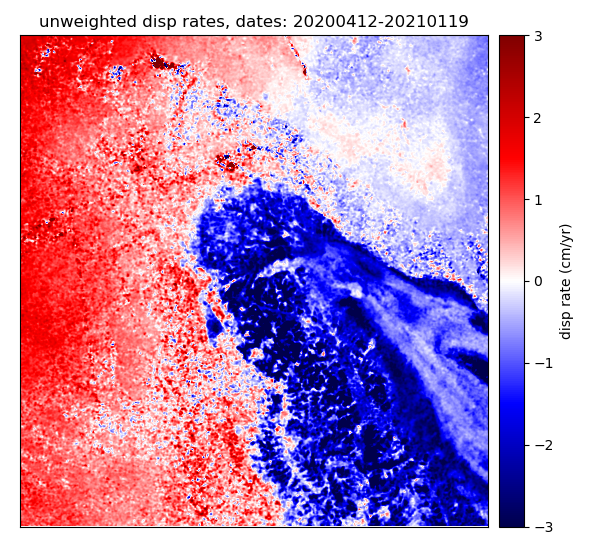

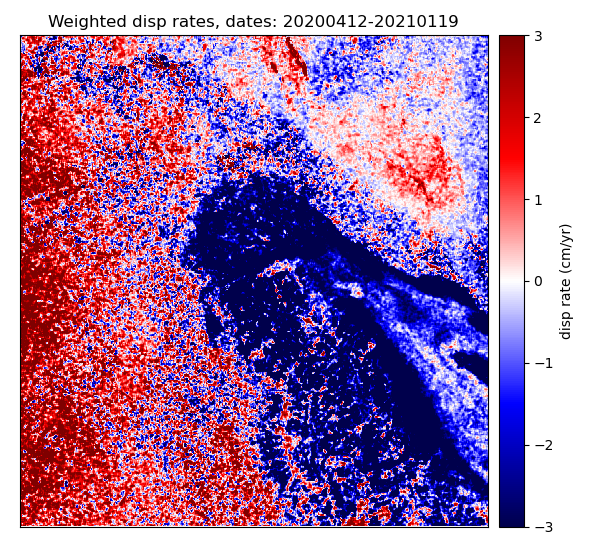

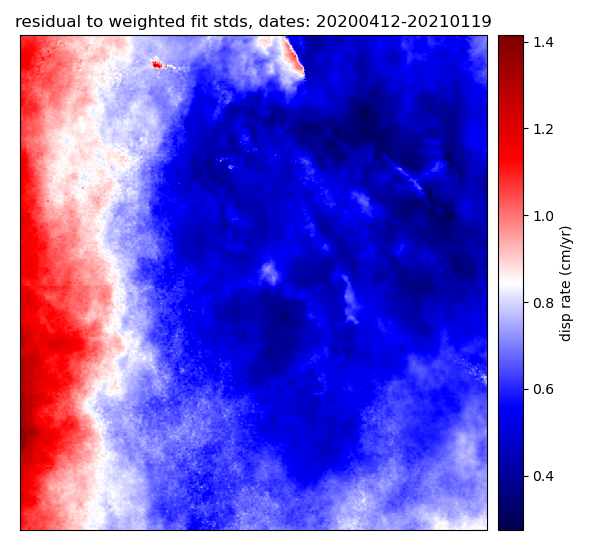

In [13]:
i = 6 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_index])+'-'+str(dates[end_index]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-3.0,vmax=3.0,extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('unweighted disp rates, dates: '+str(dates[start_index])+'-'+str(dates[end_index]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_weighted, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('Weighted disp rates, dates: '+str(dates[start_index])+'-'+str(dates[end_index]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_residual_std*rad2cm, aspect='auto', \
    interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('residual to weighted fit stds, dates: '+str(dates[start_index])+'-'+str(dates[end_index]))
plt.show()